# 1. Loading the Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# 2. Loading the Dataset

In [3]:
sales = pd.read_csv('/Users/raghav/Downloads/stores_sales_forecasting.csv', encoding="unicode_escape")

# 3. Data Exploration

In [4]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

In [6]:
sales.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,5041.643564,55726.556341,349.834887,3.785007,0.173923,8.699327
std,2885.740258,32261.888225,503.179145,2.251620,0.181547,136.049246
min,1.000000,1040.000000,1.892000,1.000000,0.000000,-1862.312400
25%,2568.000000,22801.000000,47.040000,2.000000,0.000000,-12.849000
50%,5145.000000,60505.000000,182.220000,3.000000,0.200000,7.774800
75%,7534.000000,90032.000000,435.168000,5.000000,0.300000,33.726600
max,9991.000000,99301.000000,4416.174000,14.000000,0.700000,1013.127000


In [7]:
#Number of null values
sales.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [8]:
#Number of Unique values
sales.columns
for i in list(sales.columns):
    print(i, sales[i].nunique(dropna=True))

Row ID 2121
Order ID 1764
Order Date 889
Ship Date 960
Ship Mode 4
Customer ID 707
Customer Name 707
Segment 3
Country 1
City 371
State 48
Postal Code 454
Region 4
Product ID 375
Category 1
Sub-Category 4
Product Name 380
Sales 1636
Quantity 14
Discount 11
Profit 1777


# 4. Exploratory Data Analysis

In [9]:
#Dropping extra columns
sales = sales.drop(columns = ['Order ID', 'Country', 'Product Name', 'Category'])

In [10]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'])

#Difference in days between Ship Date and Order Date
sales['Shipping Duration'] = (sales['Ship Date'] - sales['Order Date']).dt.days

#Correlation between Shipping Duration and Sales
correlation = sales['Shipping Duration'].corr(sales['Sales'])

correlation

-0.01012066543555678

In [11]:
def identify_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    return outliers

#Outliers in the 'Sales' column
outliers_sales = identify_outliers_iqr(sales, 'Sales')

outliers_sales

,Row ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Sub-Category,Sales,Quantity,Discount,Profit,Shipping Duration
4,11,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,FUR-TA-10001539,Tables,1706.184,9,0.20,85.3092,5
6,25,2015-09-25,2015-09-30,Standard Class,EB-13870,Emily Burns,Consumer,Orem,Utah,84057,West,FUR-TA-10000577,Tables,1044.630,3,0.00,240.2649,5
7,28,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,Philadelphia,Pennsylvania,19140,East,FUR-BO-10004834,Bookcases,3083.430,7,0.50,-1665.0522,4
35,150,2016-12-05,2016-12-09,Standard Class,JE-16165,Justin Ellison,Corporate,Franklin,Wisconsin,53132,Central,FUR-CH-10000454,Chairs,1951.840,8,0.00,585.5520,4
37,168,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,San Antonio,Texas,78207,Central,FUR-CH-10004287,Chairs,1740.060,9,0.30,-24.8580,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,9742,2015-11-08,2015-11-12,Standard Class,QJ-19255,Quincy Jones,Corporate,Burlington,Vermont,5408,East,FUR-BO-10004834,Bookcases,4404.900,5,0.00,1013.1270,4
2069,9760,2016-10-31,2016-11-05,Standard Class,SF-20965,Sylvia Foulston,Corporate,San Francisco,California,94109,West,FUR-CH-10001854,Chairs,1403.920,5,0.20,70.1960,5
2074,9788,2017-03-27,2017-04-01,Standard Class,CJ-12010,Caroline Jumper,Consumer,Houston,Texas,77070,Central,FUR-BO-10001811,Bookcases,1023.332,5,0.32,-30.0980,5
2092,9858,2015-03-26,2015-03-30,Standard Class,EB-13840,Ellis Ballard,Corporate,Seattle,Washington,98103,West,FUR-TA-10001889,Tables,3393.680,8,0.00,610.8624,4


In [12]:
sales.index

RangeIndex(start=0, stop=2121, step=1)

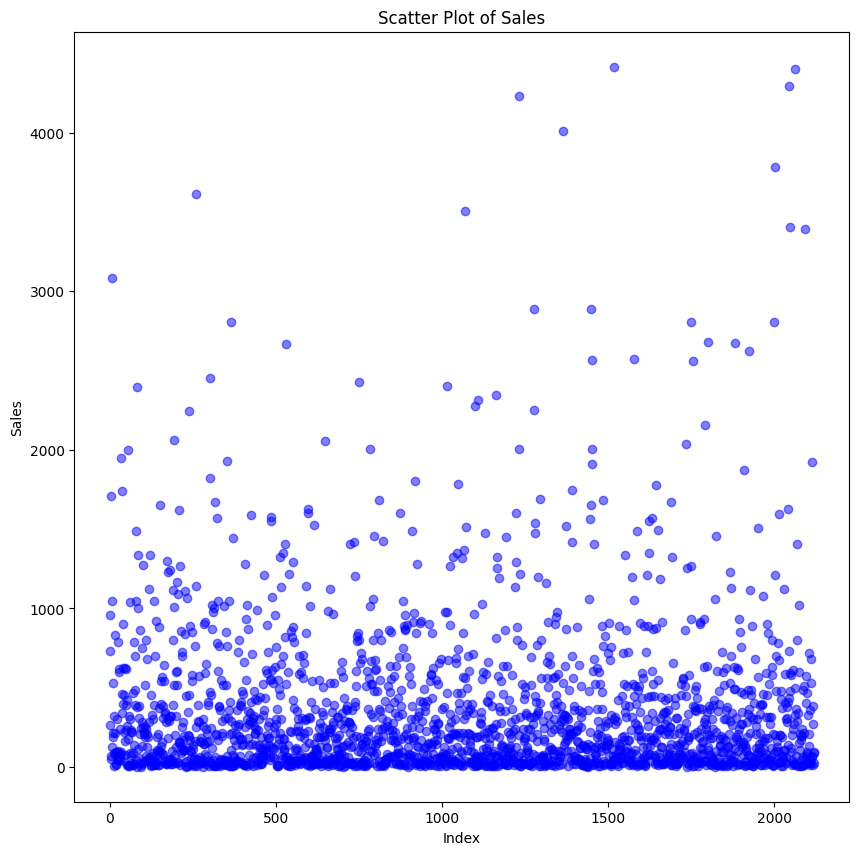

In [13]:
#Scatter plot of the Sales column
plt.figure(figsize=(10, 10))
plt.scatter(sales.index, sales['Sales'], alpha=0.5, color='blue')
plt.title('Scatter Plot of Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.show()

In [14]:
#Checking duplicate values
duplicate_records = sales[sales.duplicated()]
duplicate_records

,Row ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Sub-Category,Sales,Quantity,Discount,Profit,Shipping Duration


In [16]:
#Setting Order Date as the index
sales.set_index('Order Date', inplace=True)

In [17]:
#Total sales revenue per month
monthly_sales = sales['Sales'].resample('M').sum()
monthly_sales

Order Date
2014-01-31     6242.5250
2014-02-28     1839.6580
2014-03-31    14573.9560
2014-04-30     7944.8370
2014-05-31     6912.7870
2014-06-30    13206.1256
2014-07-31    10821.0510
2014-08-31     7320.3465
2014-09-30    23816.4808
2014-10-31    12304.2470
2014-11-30    21564.8727
2014-12-31    30645.9665
2015-01-31    11739.9416
2015-02-28     3134.3740
2015-03-31    12499.7830
2015-04-30    10475.6985
2015-05-31     9374.9505
2015-06-30     7714.1790
2015-07-31    13674.4200
2015-08-31     9638.5922
2015-09-30    26273.0230
2015-10-31    12026.6235
2015-11-30    30880.8325
2015-12-31    23085.8192
2016-01-31     7622.7430
2016-02-29     3925.5510
2016-03-31    12801.0920
2016-04-30    13212.0900
2016-05-31    15119.8350
2016-06-30    13070.5720
2016-07-31    13068.5190
2016-08-31    12483.2323
2016-09-30    27262.8809
2016-10-31    11872.5770
2016-11-30    31783.6288
2016-12-31    36678.7150
2017-01-31     5964.0320
2017-02-28     6866.3374
2017-03-31    10893.4448
2017-04-30    

# 5. Data Visualization

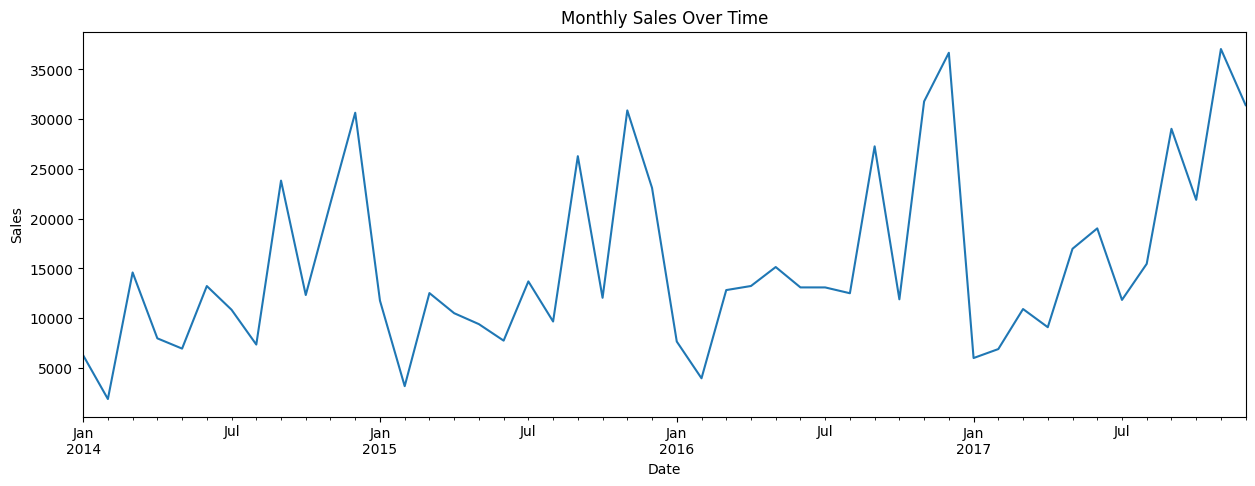

In [18]:
#Monthly Sales Trend
plt.figure(figsize=(15, 5))
monthly_sales.plot()
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

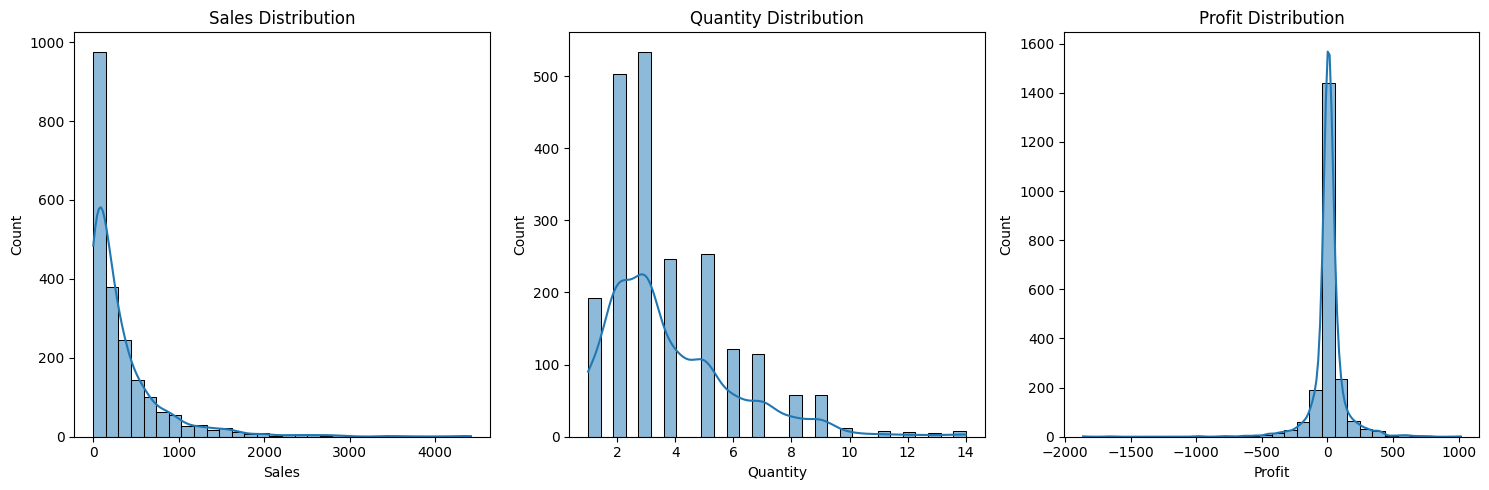

In [19]:
plt.figure(figsize=(15, 5))

# Sales Distribution
plt.subplot(1, 3, 1)
sns.histplot(sales['Sales'], bins=30, kde=True)
plt.title('Sales Distribution')

# Quantity Distribution
plt.subplot(1, 3, 2)
sns.histplot(sales['Quantity'], bins=30, kde=True)
plt.title('Quantity Distribution')

# Profit Distribution
plt.subplot(1, 3, 3)
sns.histplot(sales['Profit'], bins=30, kde=True)
plt.title('Profit Distribution')

plt.tight_layout()
plt.show()

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_36541/2915713877.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sales.corr(), annot=True, cmap='coolwarm', linewidths=0.5)


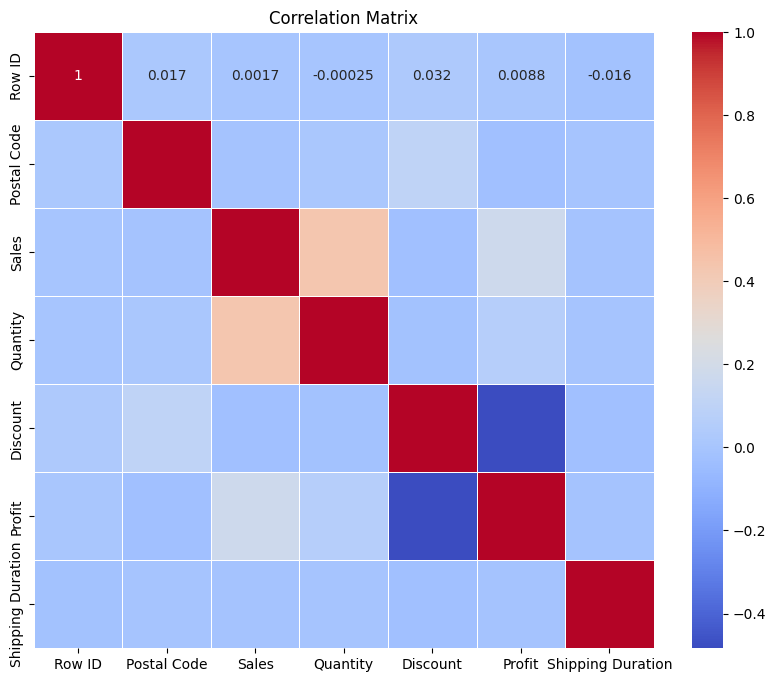

In [20]:
#Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(sales.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_36541/1857623880.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sub-Category', y='Sales', data=sales, estimator=sum, ci=None)


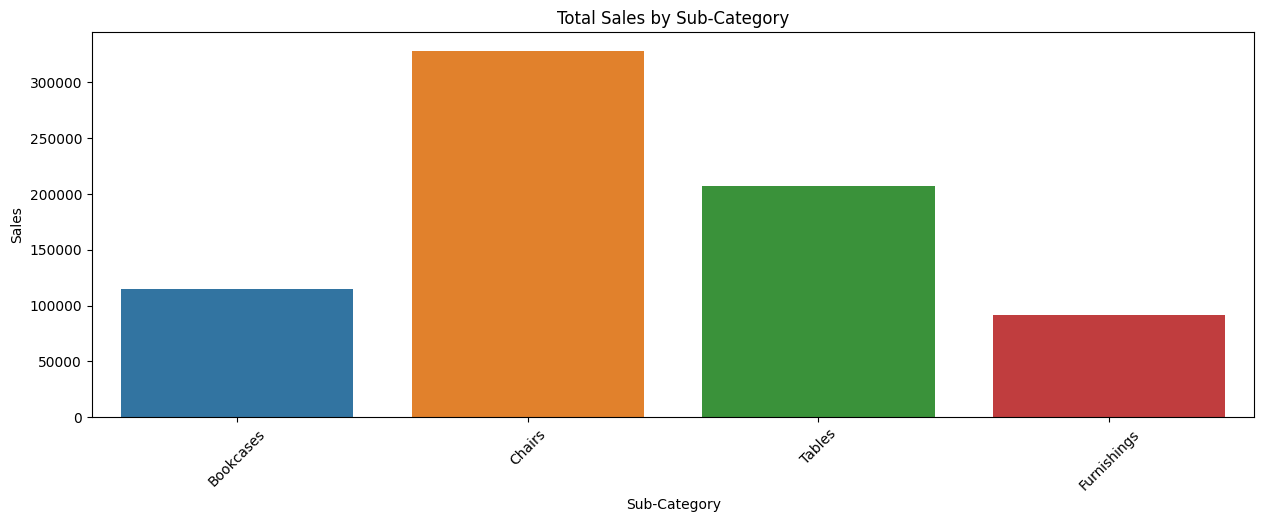

In [21]:
#Total Sales per sub-category
plt.figure(figsize=(15, 5))
sns.barplot(x='Sub-Category', y='Sales', data=sales, estimator=sum, ci=None)
plt.title('Total Sales by Sub-Category')
plt.xticks(rotation=45)
plt.show()

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_36541/4054419732.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Ship Mode', y='Sales', data=sales, estimator=sum, ci=None)


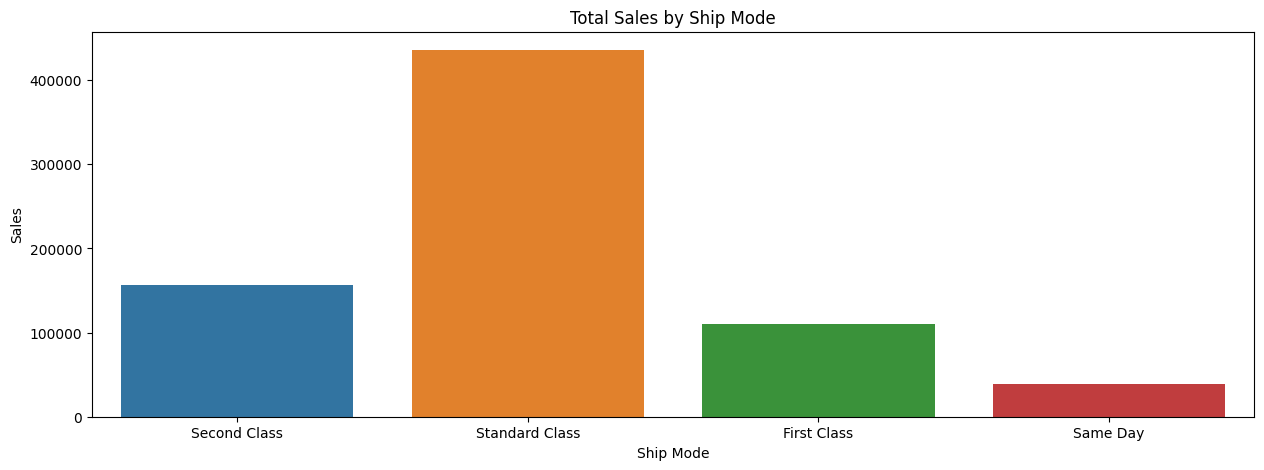

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_36541/4054419732.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Ship Mode', y='Profit', data=sales, estimator=sum, ci=None)


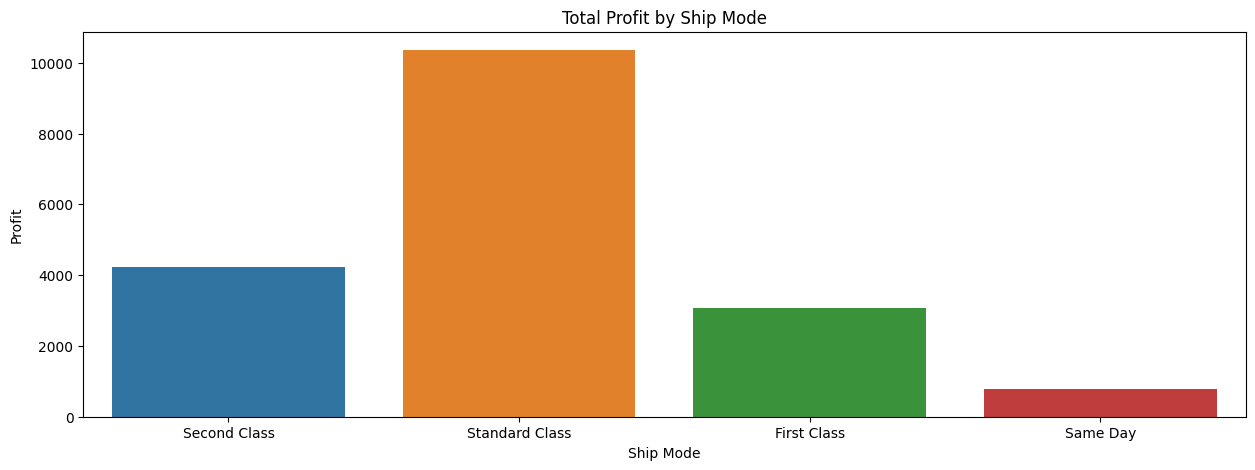

In [22]:
#Total Sales by ship mode | Total Profit by ship mode
plt.figure(figsize=(15, 5))
sns.barplot(x='Ship Mode', y='Sales', data=sales, estimator=sum, ci=None)
plt.title('Total Sales by Ship Mode')
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='Ship Mode', y='Profit', data=sales, estimator=sum, ci=None)
plt.title('Total Profit by Ship Mode')
plt.show()


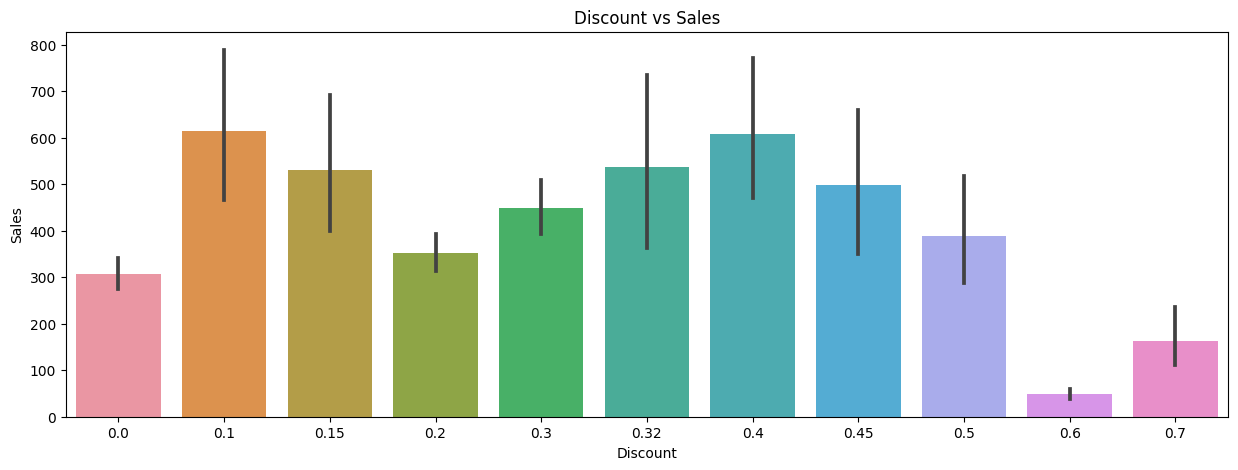

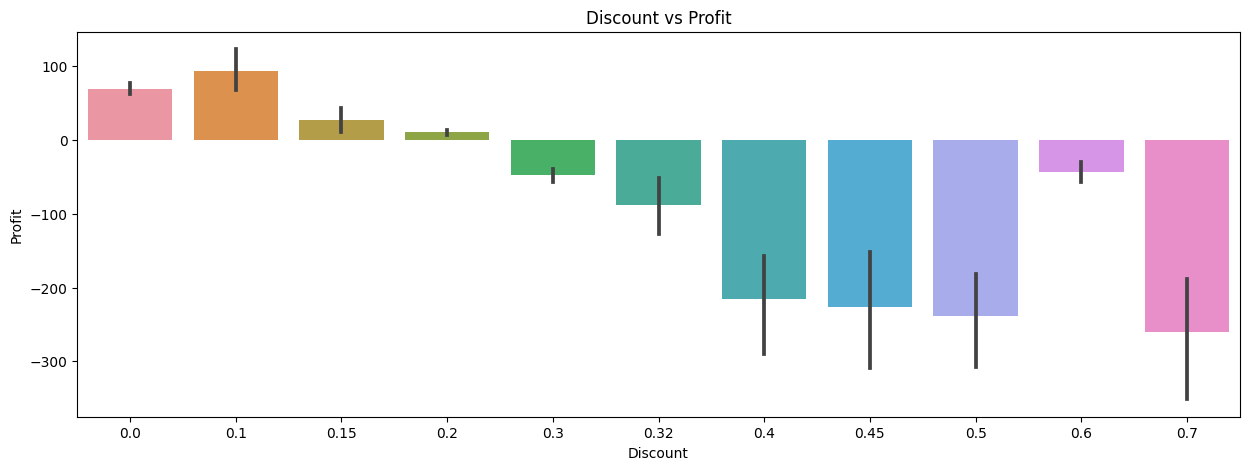

In [23]:
#Discount Vs Sales | Discount Vs Profit
plt.figure(figsize=(15, 5))
sns.barplot(x='Discount', y='Sales', data=sales)
plt.title('Discount vs Sales')
plt.show()

plt.figure(figsize=(15, 5))
sns.barplot(x='Discount', y='Profit', data=sales)
plt.title('Discount vs Profit')
plt.show()

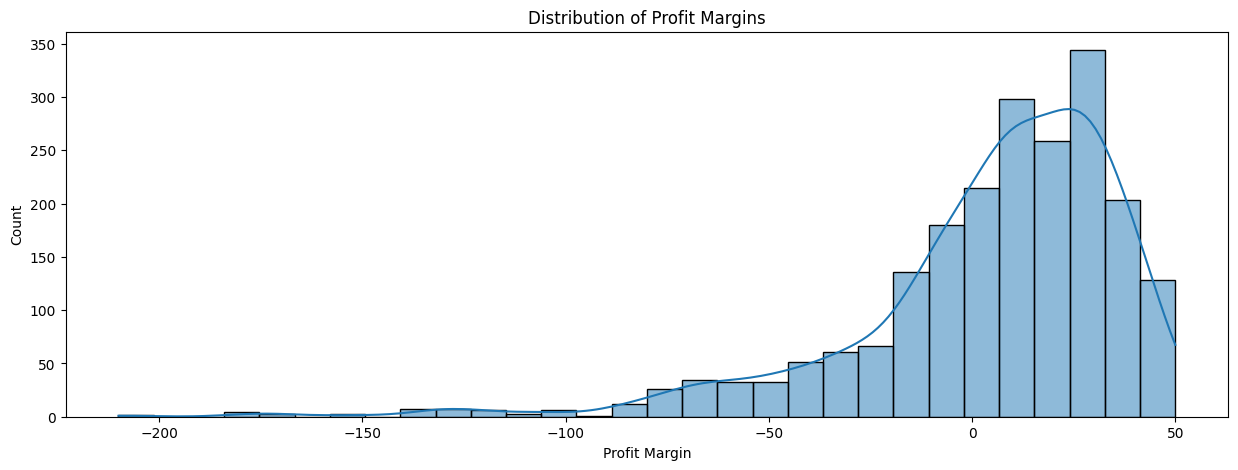

In [24]:
#Profit Margin Distribution
sales['Profit Margin'] = sales['Profit'] / sales['Sales'] * 100

plt.figure(figsize=(15, 5))
sns.histplot(sales['Profit Margin'], bins=30, kde=True)
plt.title('Distribution of Profit Margins')
plt.show()

In [25]:
#Coefficient of Variation for the Sales column
mean_sales = sales['Sales'].mean()
std_sales = sales['Sales'].std()
cv_sales = std_sales / mean_sales

cv_sales

1.4383332352811926

The above value of Coefficient of variation indicates a quite high variability in the Sales column

In [ ]:
#CV of CV

In [117]:
# Summary statistics for the Sales column
summary_stats = sales['Sales'].describe()
summary_stats

count    2121.000000
mean      349.834887
std       503.179145
min         1.892000
25%        47.040000
50%       182.220000
75%       435.168000
max      4416.174000
Name: Sales, dtype: float64

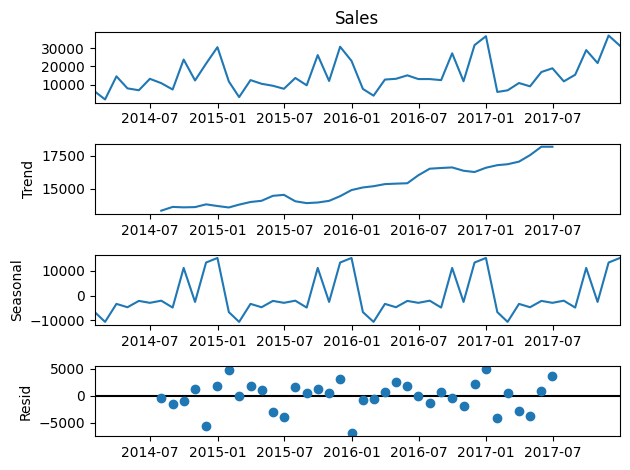

In [33]:
#Seasonality Decomposition
decomposition = seasonal_decompose(monthly_sales, model='additive')
decomposition.plot()
plt.show()

<Axes: xlabel='Order Date'>

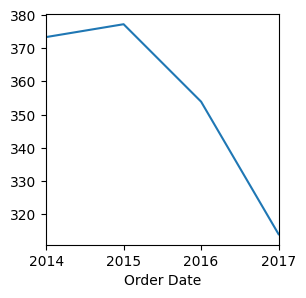

In [27]:
#Annual trend in Sales
Y_Sales = sales['Sales'].resample('Y').mean()

Y_Sales.plot(figsize =(3,3))

<Axes: xlabel='Order Date'>

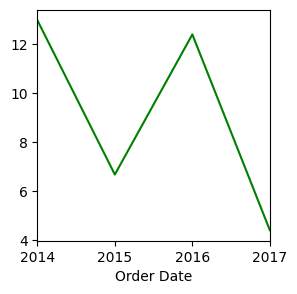

In [28]:
#Annual trend in profit
Y_Profit = sales['Profit'].resample('Y').mean()

Y_Profit.plot(figsize =(3,3), c= "g")

<Axes: xlabel='Order Date'>

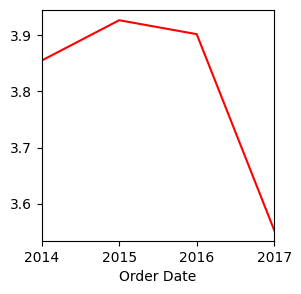

In [29]:
#Annual trendin Quantity
Y_Quantity = sales['Quantity'].resample('Y').mean()

Y_Quantity.plot(figsize =(3,3), c ="r")

<Axes: xlabel='Order Date'>

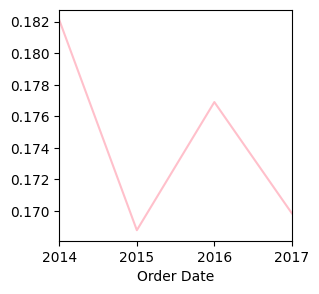

In [30]:
#Annual trend in Discount
Y_Discount = sales['Discount'].resample('Y').mean()

Y_Discount.plot(figsize =(3,3), c ="pink", )

Next up - 
ADF test,
Autocorrelation plots,
Model Building & Optimization,
Forecasting,
Conclusion.